In [12]:
import sys
import tensorflow.keras
import tensorflow as tf

print(f"tensorflow version : {tf.__version__}")
# print(f"keras version : {tensorflow.keras.__version__}")

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is " , "Available" if gpu else "NOT available")

tensorflow version : 2.13.0
GPU is  Available


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from sklearn.metrics import precision_score
from tensorflow.keras import regularizers
import shutil
import glob
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, AveragePooling2D, Flatten, Dense
from keras.layers import Conv2D , GlobalAveragePooling2D , MaxPooling2D,Dropout , Flatten , Dense, BatchNormalization, GlobalAvgPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
import tensorflow as tf
from tensorflow.keras.layers import GaussianNoise
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.python.framework.func_graph import flatten
from keras.callbacks import ModelCheckpoint , EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.models import Model , load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import  InceptionV3
from tensorflow.keras.applications.inception_v3 import  preprocess_input
from sklearn.model_selection import KFold
from keras.callbacks import Callback

In [14]:
import os

root_dir = "data"
number_of_images = {}

for dir in os.listdir(root_dir):
    # Ignore .DS_Store files
    if dir == '.DS_Store':
        continue

    # Check if the item is a directory before listing its contents
    if os.path.isdir(os.path.join(root_dir, dir)):
        number_of_images[dir] = len(os.listdir(os.path.join(root_dir, dir)))

print(number_of_images.items())


dict_items([('cat', 5000), ('dog', 5000), ('truck', 5000), ('bird', 5000), ('airplane', 5000), ('ship', 5000), ('frog', 5000), ('horse', 5000), ('deer', 5000), ('automobile', 5000)])


In [15]:
def foldercreation (path , split) :
    if not os.path.exists('./'+path):
      os.mkdir('./'+path)

      for dir in os.listdir(root_dir):
        if dir == '.DS_Store':
           continue
            
        os.makedirs('./'+path+"/"+dir)

        for img in np.random.choice(a=os.listdir(os.path.join(root_dir,dir)) , size = (math.floor(split * number_of_images[dir])-5) , replace=False):
          Original = os.path.join(root_dir,dir,img)
          Destination =os.path.join('./'+path , dir)
          shutil.copy(Original,Destination)
          # os.remove(Original)

    else:
      print("The folder exsist")

In [16]:
foldercreation("train_data",0.7)
foldercreation("validation_data",0.15)
foldercreation("test_data",0.15)

The folder exsist
The folder exsist
The folder exsist


In [17]:
image_data = ImageDataGenerator (
                                     
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      preprocessing_function= preprocess_input,
                                )

image=image_data.flow_from_directory(directory="train_data" ,
                                       target_size=(28,28),
                                       batch_size=32,
                                       shuffle=True,
                                       class_mode="categorical")

Found 34950 images belonging to 10 classes.


In [18]:
def preprocessing2 (path):
  image_data = ImageDataGenerator(preprocessing_function= preprocess_input)
  image = image_data.flow_from_directory(directory = path,
                                         target_size=(28,28),
                                         batch_size = 32,
                                         shuffle=True,
                                         class_mode = "categorical")
  return image

In [19]:
path_test ="test_data"
test_data = preprocessing2(path_test)
X_test , Y_test = test_data.next()

Found 7450 images belonging to 10 classes.


In [20]:
path_validate="validation_data"
validate_data = preprocessing2(path_validate)
validate_data_1 , validate_labels = validate_data.next()

Found 7450 images belonging to 10 classes.


In [21]:
def model_layer_1 (inputs,filters):


  convo_2x2 = Conv2D(filters=filters[0], kernel_size=(2,2), padding='same', activation='relu')(inputs)
  convo_3x3 = Conv2D(filters=filters[1], kernel_size=(3,3), padding='same', activation='relu')(inputs)
  pool_conv = Conv2D(filters=filters[2], kernel_size=(5,5), padding='same', activation='relu')(inputs)


  outputs = Concatenate(axis=-1)([convo_2x2, convo_3x3, pool_conv])

  return outputs


def model_layer_2 (inputs,filters):



  convo_3x3 = Conv2D(filters=filters[0], kernel_size=(2,2), padding='same', activation='relu')(inputs)
  pool_3x3 =MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same')(convo_3x3)

  convo_5x5 = Conv2D(filters=filters[1], kernel_size=(3,3), padding='same', activation='relu')(inputs)
  pool_5x5 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(convo_5x5)


  outputs = Concatenate(axis=-1)([pool_3x3, pool_5x5])

  return outputs


def model_layer_3 (inputs,filters):
    
  convo_1x1 = Conv2D(filters=filters[0], kernel_size=(3,3), padding='same', activation='relu')(inputs)
  pool_1x1 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(inputs)
  outputs = Concatenate(axis=-1)([pool_1x1, convo_1x1])

  return outputs


# def model_layer_5 (inputs,filters):
    
#   convo_1x1 = Conv2D(filters=filters[0], kernel_size=(5,5), padding='same', activation='relu')(inputs)
#   pool_1x1 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(inputs)
#   outputs = Concatenate(axis=-1)([pool_1x1, convo_1x1])

#   return outputs

# def model_layer_6 (inputs):
    
#   pool_3x3 = MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same')(inputs)
#   pool_1x1 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(inputs)
#   outputs = Concatenate(axis=-1)([pool_1x1, pool_3x3])

#   return outputs

    




In [22]:
from keras.layers import Input
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout

# define input tensor

input_tensor = Input(shape=(28, 28, 3))


original_model = model_layer_3(input_tensor,[128])
original_model = MaxPooling2D(pool_size=(2,2) ,padding='same')(original_model)


original_model = model_layer_1(original_model,[32,64,128])
original_model = MaxPooling2D(pool_size=(2,2),padding='same')(original_model)
original_model = model_layer_2(original_model,[128,64])

original_model = MaxPooling2D(pool_size=(2,2) ,padding='same')(original_model)
original_model = model_layer_3(original_model,[128])






In [23]:

original_model = Flatten()(original_model)
original_model = Dense(512, activation='relu' ,kernel_regularizer=regularizers.l2(0.001))(original_model)
original_model = Dense(256, activation='relu' ,kernel_regularizer=regularizers.l2(0.001))(original_model)
original_model = Dropout(0.5)(original_model)

output_tensor = Dense(10, activation='softmax' ,kernel_regularizer=regularizers.l2(0.001))(original_model)

original_model = Model(inputs=input_tensor, outputs=output_tensor)

In [24]:
original_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28, 28, 3)]          0         []                            
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 3)            0         ['input_2[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d_4 (Conv2D)           (None, 28, 28, 128)          3584      ['input_2[0][0]']             
                                                                                                  
 concatenate_1 (Concatenate  (None, 28, 28, 131)          0         ['max_pooling2d_2[0][0]', 

In [25]:


opt = keras.optimizers.Adam()
original_model.compile(optimizer= opt ,
              loss= keras.losses.categorical_crossentropy,
              metrics=['accuracy' , 'AUC'])

In [26]:
earlystop = EarlyStopping(monitor="accuracy",
                          min_delta=0.002 , patience=3,
                          verbose=1,
                          mode="auto")
modelcheckpoint = ModelCheckpoint(monitor="accuracy",
                                  filepath = "./relu.h5",
                                  verbose=1,
                                  save_best_only=True,
                                  mode ="auto"
                                  )
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-3)


class MetricsCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data[0], self.validation_data[1]
        predictions = self.model.predict(x_val)
        
        # Calculate top-5 accuracy
        top_5 = np.argsort(predictions, axis=1)[:, -5:]
        true_labels = np.argmax(y_val, axis=1)
        top_5_accuracy = np.mean([1 if true_label in pred_classes else 0 for true_label, pred_classes in zip(true_labels, top_5)])
        
        # Calculate precision
        precision = precision_score(true_labels, np.argmax(predictions, axis=1), average='weighted')
        
        print(f'Epoch {epoch + 1} - Top-5 Accuracy: {top_5_accuracy:.4f} - Precision: {precision:.4f}')


metrics_callback = MetricsCallback(validation_data=(validate_data_1, validate_labels))

callbs = [earlystop,modelcheckpoint,lr_scheduler,metrics_callback]

In [27]:
final = original_model.fit(
    image,
    steps_per_epoch=len(image),
    epochs=30,
    validation_data=(validate_data_1, validate_labels),
    validation_steps=len(validate_data_1),
    verbose=1,
    callbacks=callbs)
    

Epoch 1/30


2023-12-20 12:39:51.553509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1093/1093 [==============================] - ETA: 0s - loss: 1.9522 - accuracy: 0.3528 - auc: 0.8144

2023-12-20 12:41:16.655762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: accuracy improved from -inf to 0.35279, saving model to ./relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 235ms/step
Epoch 1 - Top-5 Accuracy: 0.9375 - Precision: 0.3835
1093/1093 [==============================] - 88s 79ms/step - loss: 1.9522 - accuracy: 0.3528 - auc: 0.8144 - val_loss: 1.4945 - val_accuracy: 0.4375 - val_auc: 0.8817 - lr: 0.0010
Epoch 2/30


2023-12-20 12:41:19.319674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 1.5528 - accuracy: 0.4563 - auc: 0.8703
Epoch 2: accuracy improved from 0.35279 to 0.45631, saving model to ./relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 42ms/step
Epoch 2 - Top-5 Accuracy: 0.9375 - Precision: 0.4776
1093/1093 [==============================] - 85s 78ms/step - loss: 1.5528 - accuracy: 0.4563 - auc: 0.8703 - val_loss: 1.2668 - val_accuracy: 0.4688 - val_auc: 0.9178 - lr: 0.0010
Epoch 3/30


/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 1.4629 - accuracy: 0.4920 - auc: 0.8844
Epoch 3: accuracy improved from 0.45631 to 0.49205, saving model to ./relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 54ms/step
Epoch 3 - Top-5 Accuracy: 0.9375 - Precision: 0.6914
1093/1093 [==============================] - 90s 82ms/step - loss: 1.4629 - accuracy: 0.4920 - auc: 0.8844 - val_loss: 1.2603 - val_accuracy: 0.6250 - val_auc: 0.9149 - lr: 0.0010
Epoch 4/30


/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 1.4064 - accuracy: 0.5165 - auc: 0.8926
Epoch 4: accuracy improved from 0.49205 to 0.51648, saving model to ./relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 37ms/step
Epoch 4 - Top-5 Accuracy: 0.9375 - Precision: 0.5969
1093/1093 [==============================] - 89s 81ms/step - loss: 1.4064 - accuracy: 0.5165 - auc: 0.8926 - val_loss: 1.3157 - val_accuracy: 0.5000 - val_auc: 0.9080 - lr: 0.0010
Epoch 5/30
   1/1093 [..............................] - ETA: 2:43 - loss: 1.3073 - accuracy: 0.5312 - auc: 0.9112

/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 1.3541 - accuracy: 0.5330 - auc: 0.9002
Epoch 5: accuracy improved from 0.51648 to 0.53299, saving model to ./relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 38ms/step
Epoch 5 - Top-5 Accuracy: 0.9688 - Precision: 0.6602
1093/1093 [==============================] - 91s 84ms/step - loss: 1.3541 - accuracy: 0.5330 - auc: 0.9002 - val_loss: 1.2551 - val_accuracy: 0.5625 - val_auc: 0.9132 - lr: 0.0010
Epoch 6/30
1093/1093 [==============================] - ETA: 0s - loss: 1.3372 - accuracy: 0.5409 - auc: 0.9025
Epoch 6: accuracy improved from 0.53299 to 0.54092, saving model to ./relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 34ms/step
Epoch 6 - Top-5 Accuracy: 0.9688 - Precision: 0.6868
1093/1093 [==============================] - 90s 82ms/step - loss: 1.3372 - accuracy: 0.5409 - auc: 0.9025 - val_loss: 1.1194 - val_accuracy: 0.5938 - val_auc: 0.9346 - lr: 0.0010
Epoch 7/30


/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 1.3105 - accuracy: 0.5518 - auc: 0.9057
Epoch 7: accuracy improved from 0.54092 to 0.55182, saving model to ./relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 37ms/step
Epoch 7 - Top-5 Accuracy: 0.8438 - Precision: 0.5573
1093/1093 [==============================] - 97s 88ms/step - loss: 1.3105 - accuracy: 0.5518 - auc: 0.9057 - val_loss: 1.5558 - val_accuracy: 0.4375 - val_auc: 0.8610 - lr: 0.0010
Epoch 8/30
   1/1093 [..............................] - ETA: 2:27 - loss: 1.8670 - accuracy: 0.4062 - auc: 0.8097

/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 1.2872 - accuracy: 0.5632 - auc: 0.9091
Epoch 8: accuracy improved from 0.55182 to 0.56320, saving model to ./relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 47ms/step
Epoch 8 - Top-5 Accuracy: 0.9375 - Precision: 0.5312
1093/1093 [==============================] - 102s 93ms/step - loss: 1.2872 - accuracy: 0.5632 - auc: 0.9091 - val_loss: 1.1789 - val_accuracy: 0.4688 - val_auc: 0.9255 - lr: 0.0010
Epoch 9/30
1093/1093 [==============================] - ETA: 0s - loss: 1.2663 - accuracy: 0.5666 - auc: 0.9117
Epoch 9: accuracy improved from 0.56320 to 0.56664, saving model to ./relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 27ms/step
Epoch 9 - Top-5 Accuracy: 0.9062 - Precision: 0.5052
1093/1093 [==============================] - 89s 81ms/step - loss: 1.2663 - accuracy: 0.5666 - auc: 0.9117 - val_loss: 1.3998 - val_accuracy: 0.4688 - val_auc: 0.8947 - lr: 0.0010
Epoch 10/30
   1/1093 [..............................] - ETA: 2:50 - loss: 0.9675 - accuracy: 0.6562 - auc: 0.9488

/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 1.2303 - accuracy: 0.5802 - auc: 0.9162
Epoch 10: accuracy improved from 0.56664 to 0.58017, saving model to ./relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 32ms/step
Epoch 10 - Top-5 Accuracy: 1.0000 - Precision: 0.5554
1093/1093 [==============================] - 91s 83ms/step - loss: 1.2303 - accuracy: 0.5802 - auc: 0.9162 - val_loss: 1.0226 - val_accuracy: 0.5625 - val_auc: 0.9457 - lr: 0.0010
Epoch 11/30
   1/1093 [..............................] - ETA: 2:04 - loss: 1.1189 - accuracy: 0.6250 - auc: 0.9257

/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 1.2213 - accuracy: 0.5855 - auc: 0.9176
Epoch 11: accuracy improved from 0.58017 to 0.58549, saving model to ./relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 41ms/step
Epoch 11 - Top-5 Accuracy: 0.9062 - Precision: 0.6172
1093/1093 [==============================] - 86s 78ms/step - loss: 1.2213 - accuracy: 0.5855 - auc: 0.9176 - val_loss: 1.1801 - val_accuracy: 0.5625 - val_auc: 0.9232 - lr: 0.0010
Epoch 12/30
1093/1093 [==============================] - ETA: 0s - loss: 1.2283 - accuracy: 0.5809 - auc: 0.9171
Epoch 12: accuracy did not improve from 0.58549
1/1 [==============================] - 0s 39ms/step
Epoch 12 - Top-5 Accuracy: 1.0000 - Precision: 0.6589
1093/1093 [==============================] - 86s 79ms/step - loss: 1.2283 - accuracy: 0.5809 - auc: 0.9171 - val_loss: 1.2319 - val_accuracy: 0.5625 - val_auc: 0.9206 - lr: 0.0010
Epoch 13/30
1093/1093 [==============================] - ETA: 0s - loss: 1.2335 - accuracy: 0.5844 - auc: 0.9159
Epoch 13: accuracy did not improve from 0.58549
1/1 [==============================] - 0s 32ms/step
Epoch 13 - Top-5 Accuracy: 1.0000 - Precision: 0.5151


/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 1.2190 - accuracy: 0.5882 - auc: 0.9178
Epoch 14: accuracy improved from 0.58549 to 0.58815, saving model to ./relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 42ms/step
Epoch 14 - Top-5 Accuracy: 0.9062 - Precision: 0.5120
1093/1093 [==============================] - 91s 83ms/step - loss: 1.2190 - accuracy: 0.5882 - auc: 0.9178 - val_loss: 1.3814 - val_accuracy: 0.5312 - val_auc: 0.8984 - lr: 0.0010
Epoch 15/30
   1/1093 [..............................] - ETA: 1:48 - loss: 1.2663 - accuracy: 0.5625 - auc: 0.9206

/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 1.1814 - accuracy: 0.5997 - auc: 0.9225
Epoch 15: accuracy improved from 0.58815 to 0.59974, saving model to ./relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 38ms/step
Epoch 15 - Top-5 Accuracy: 0.9688 - Precision: 0.7237
1093/1093 [==============================] - 88s 81ms/step - loss: 1.1814 - accuracy: 0.5997 - auc: 0.9225 - val_loss: 1.2392 - val_accuracy: 0.5938 - val_auc: 0.9228 - lr: 0.0010
Epoch 16/30
1093/1093 [==============================] - ETA: 0s - loss: 1.2112 - accuracy: 0.5914 - auc: 0.9185
Epoch 16: accuracy did not improve from 0.59974
1/1 [==============================] - 0s 37ms/step
Epoch 16 - Top-5 Accuracy: 0.9062 - Precision: 0.5641
1093/1093 [==============================] - 94s 86ms/step - loss: 1.2112 - accuracy: 0.5914 - auc: 0.9185 - val_loss: 1.6060 - val_accuracy: 0.5000 - val_auc: 0.8745 - lr: 0.0010
Epoch 17/30


/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 1.2239 - accuracy: 0.5854 - auc: 0.9161
Epoch 17: accuracy did not improve from 0.59974
1/1 [==============================] - 0s 41ms/step
Epoch 17 - Top-5 Accuracy: 0.9688 - Precision: 0.6969
1093/1093 [==============================] - 99s 91ms/step - loss: 1.2239 - accuracy: 0.5854 - auc: 0.9161 - val_loss: 1.2117 - val_accuracy: 0.6250 - val_auc: 0.9142 - lr: 0.0010
Epoch 18/30
   1/1093 [..............................] - ETA: 2:53 - loss: 1.7238 - accuracy: 0.5625 - auc: 0.8481

/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 1.2098 - accuracy: 0.5914 - auc: 0.9181
Epoch 18: accuracy did not improve from 0.59974
1/1 [==============================] - 0s 35ms/step
Epoch 18 - Top-5 Accuracy: 0.9688 - Precision: 0.4943
1093/1093 [==============================] - 95s 87ms/step - loss: 1.2098 - accuracy: 0.5914 - auc: 0.9181 - val_loss: 1.2347 - val_accuracy: 0.5000 - val_auc: 0.9227 - lr: 0.0010
Epoch 18: early stopping


/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
image.class_indices

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [29]:
import numpy as np
from sklearn.metrics import precision_score

def calculate_metrics(true_labels, predictions):
    # Calculate top-5 accuracy
    top_5 = np.argsort(predictions, axis=1)[:, -5:]
    top_5_accuracy = np.mean([1 if true_label in pred_classes else 0 for true_label, pred_classes in zip(true_labels, top_5)])

    # Calculate precision
    precision = precision_score(true_labels, np.argmax(predictions, axis=1), average='weighted')

    return top_5_accuracy, precision
    

In [30]:
prediction = original_model.evaluate(X_test , Y_test,verbose=1)
print('Test loss:', prediction[0])
print('Test accuracy:', prediction[1])

predictions = original_model.predict(X_test)
top_5_accuracy, precision = calculate_metrics(np.argmax(Y_test, axis=1), predictions)

# Print metrics
print(f' Top-5 Accuracy: {top_5_accuracy:.4f}')
print(f'Precision: {precision:.4f}')

2023-12-20 13:07:07.178865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 627ms/step - loss: 1.3840 - accuracy: 0.5625 - auc: 0.8942
Test loss: 1.3840185403823853
Test accuracy: 0.5625
1/1 [==============================] - 0s 27ms/step
 Top-5 Accuracy: 0.9688
Precision: 0.6521


/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


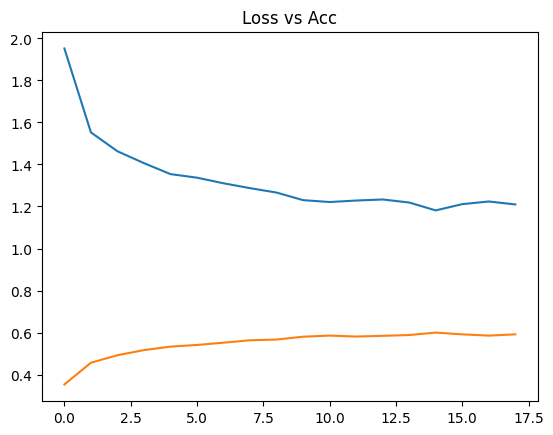

In [31]:
h = final.history
h.keys()



plt.plot(h['loss'])
plt.plot(h['accuracy'])

plt.title("Loss vs Acc")
plt.show()